# Kaggle Titanic Competition Deep Neural Network

See the [Titanic Kaggle Competition](https://www.kaggle.com/competitions/titanic/data) page for the description of this competition, and to locate the same datasets used within this project.

In [1]:
import pandas as pd
import torch
import numpy as np
import math as m
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

## 1. Hyperparameters

In [2]:
LR = 0.0005
NUM_BATCHES = 64
EPOCHS = 20000
SEED = 999

## 2. CUDA Configuration and Seed

In [3]:
# PyTorch Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("Warning CUDA not Found. Using CPU.")

# Set random seed for reproducibility
print("Random Seed Used: ", SEED)
torch.manual_seed(SEED)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed Used:  999


## 3. Load the Datasets

In [4]:
# Load the datatsets into the program 
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Save Test IDs
test_ids = test["PassengerId"]

# Combine the train and test datasets together for easier group calculations used later in preprocessing 
all = pd.concat([train, test], sort=True).reset_index(drop=True)

In [5]:
# Observe train dataset information
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Observe test dataset information
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 3.1 Dataset Overview
From analysing the datasets, the following can be determined:
* Training set has **891** rows and the test set has **418** rows
* Training set has **12** features and the test set has **11** features (as the test set has no "Survived" target) 

See below for a breakdown of all features present within the datasets: 
* `PassengerId` is the unique id of the passenger/row
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**
    
These descriptions came from https://www.kaggle.com/code/matthewlockett/titanic-advanced-feature-engineering-tutorial/edit.

## 4. Data Preprocessing 

### 4.1 Missing Data

The missing values in each dataset are as follows:
* Training set has missing values in the features `Age`, `Cabin` and `Embarked` 
* Test set has missing values in the features `Age`, `Cabin` and `Fare`

To ensure effective training and predictions these missing values will have to be dealt with and can be done in aggregation over the combined `all` dataset.

In [7]:
# Remove Unecessary Columns
all.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1, inplace=True)

# Fill Missing Embarked Values with S due to research done on passengers showing where they came from
all.fillna({"Embarked": "S"}, inplace=True)

# Fill Missing Age Values with Mean Age based on PClass and Sex
all["Age"] = all.groupby(["Sex", "Pclass"])["Age"].transform(lambda x: x.fillna(x.median()))

# Handle Categorical Data
all= pd.get_dummies(all, columns=["Pclass", "Sex", "Embarked"], dtype=int)

# Normalise Age Range 
all["Age"] = all["Age"] / all.Age.max()

# Normalise Fare Range 
all["Fare"] = np.log10(all["Fare"] + 1)
all["Fare"] = all["Fare"] / all.Fare.max()

# Normalise SibSb Range
all["SibSp"] = all["SibSp"] / all.SibSp.max()

# Normalise Parch Range
all["Parch"] = all["Parch"] / all.Parch.max()

# Extract the processed train and test datasets
train = all.loc[:890]
test = all.loc[891:].drop(['Survived'], axis=1)


# Split train set into an extra validate set
validate = train.iloc[700:, :]
train = train.iloc[:700, :]

train.head(10)

,Age,Fare,Parch,SibSp,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.2750,0.338125,0.000000,0.125,0.0,0,0,1,0,1,0,0,1
1,0.4750,0.685892,0.000000,0.125,1.0,1,0,0,1,0,1,0,0
2,0.3250,0.350727,0.000000,0.000,1.0,0,0,1,1,0,0,0,1
3,0.4375,0.639463,0.000000,0.125,1.0,1,0,0,1,0,0,0,1
4,0.4375,0.352955,0.000000,0.000,0.0,0,0,1,0,1,0,0,1
5,0.3125,0.360026,0.000000,0.000,0.0,0,0,1,0,1,0,1,0
6,0.6750,0.635755,0.000000,0.000,0.0,1,0,0,0,1,0,0,1
7,0.0250,0.495832,0.111111,0.375,0.0,0,0,1,0,1,0,0,1
8,0.3375,0.399934,0.222222,0.000,1.0,0,0,1,1,0,0,0,1
9,0.1750,0.550603,0.000000,0.125,1.0,0,1,0,1,0,1,0,0


## Model Design

In [8]:
class TabularDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
    
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.sigmoid(self.output(x))
        return x

## Data Preparation

In [9]:
# Split the features and the target (desired prediction)
X = train.drop("Survived", axis=1).values
y = train["Survived"].values
X_val = validate.drop("Survived", axis=1).values
y_val = validate["Survived"].values

# Create the dataset
dataset = TabularDataset(X, y)

# Define DataLoader
dataloader = DataLoader(dataset, batch_size=NUM_BATCHES, shuffle=True)

# Convert validate data into tensors
validate_features = torch.tensor(X_val, dtype=torch.float32).to(device)
validate_targets = torch.tensor(y_val, dtype=torch.float32).to(device)

In [10]:
def determine_accuracy(model, features, targets):

    # Set to Evaluation Mode
    model.eval()

    with torch.no_grad():

        outputs = model(features)

        # Convert to binary predictions
        predictions = torch.round(outputs.squeeze())
        total_correct = (predictions == targets).sum().item()
        total_samples = targets.size(0)

    accuracy = total_correct / total_samples

    # Set back to train mode
    model.train()

    return accuracy

## Train the Model

In [11]:
# Initialise the Model
input_dim = X.shape[1]  # Number of features
model = NeuralNetwork(input_dim).to(device)

# Set-Up Loss and Optimier Function 
criterion = nn.BCELoss()  # Use as this is a binary classification task
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [12]:
train_losses = []

# Training Loop
for epoch in range(EPOCHS):

    running_training_loss = 0.0

    for features, targets in dataloader:

        # Move onto the GPU
        features = features.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Combine this loss with all previous epoch losses
        running_training_loss += loss.item() * features.size(0)

    # This epoch loss is the average of all losses
    average_loss = running_training_loss / len(dataloader.dataset)
    train_losses.append(average_loss)

    # Print loss and accuracy every 10 epochs
    if ((epoch + 1) % 10) == 0:
        accuracy = determine_accuracy(model, validate_features, validate_targets)
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/5000], Loss: 0.5594, Accuracy: 0.6283
Epoch [20/5000], Loss: 0.4734, Accuracy: 0.8063
Epoch [30/5000], Loss: 0.4438, Accuracy: 0.8272
Epoch [40/5000], Loss: 0.4360, Accuracy: 0.8272
Epoch [50/5000], Loss: 0.4296, Accuracy: 0.8272
Epoch [60/5000], Loss: 0.4262, Accuracy: 0.8325
Epoch [70/5000], Loss: 0.4236, Accuracy: 0.8220
Epoch [80/5000], Loss: 0.4238, Accuracy: 0.8220
Epoch [90/5000], Loss: 0.4228, Accuracy: 0.8272
Epoch [100/5000], Loss: 0.4188, Accuracy: 0.8325
Epoch [110/5000], Loss: 0.4181, Accuracy: 0.8220
Epoch [120/5000], Loss: 0.4140, Accuracy: 0.8220
Epoch [130/5000], Loss: 0.4144, Accuracy: 0.8325
Epoch [140/5000], Loss: 0.4162, Accuracy: 0.8325
Epoch [150/5000], Loss: 0.4112, Accuracy: 0.8325
Epoch [160/5000], Loss: 0.4095, Accuracy: 0.8272
Epoch [170/5000], Loss: 0.4095, Accuracy: 0.8429
Epoch [180/5000], Loss: 0.4062, Accuracy: 0.8325
Epoch [190/5000], Loss: 0.4052, Accuracy: 0.8429
Epoch [200/5000], Loss: 0.4046, Accuracy: 0.8377
Epoch [210/5000], Loss: 0.404

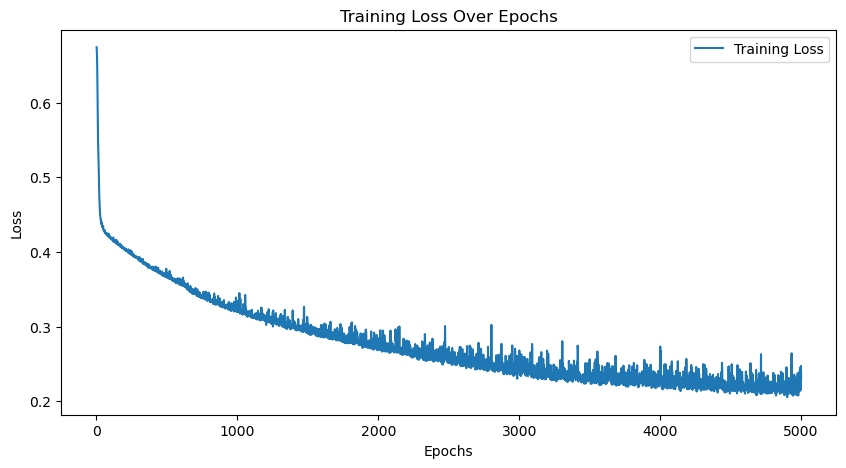

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Save Submission

In [14]:
# Convert test data to a tensor
test_features = torch.tensor(test.values, dtype=torch.float32)
test_features = test_features.to(device)

# Set to Evaluation Mode
model.eval()

predictions = []
with torch.no_grad():

    outputs = model(test_features)

    # Convert to binary predictions
    predicted_labels = torch.round(outputs).cpu().numpy()
    predictions.extend(predicted_labels)

# Convert predictions to NumPy array
predictions = np.array(predictions).astype(int)

# Save predictions as CSV file
output = pd.DataFrame({'PassengerId': test_ids.values, 'Survived': predictions.flatten()})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


/tmp/ipykernel_30437/3476333445.py:18: RuntimeWarning: invalid value encountered in cast
  predictions = np.array(predictions).astype(int)
